# Notebook 2 : Prétraitement des images de voitures

- Mapping entre les 32 classes (road, sidewalk, parking...) et les 8 groupes (human, vehicle...) que l'on veut classifier.

- Renommage des fichiers masque / image

- Sauvegarde dans un dossier "processed"

Élements dans le dossier "raw" :

- *leftImg8bit* : image en format 8-bit

- *gtFine* : images annotées (masques)

On s'inspire des fonctions helpers disponibles [ici](https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py)

## Imports

In [1]:
import os
import cv2
import numpy as np
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt


## Configuration

In [2]:
DATA_DIR = "../data"
RAW_DIR = os.path.join(DATA_DIR, "raw")
PROCESSED_DIR = os.path.join(DATA_DIR, "processed")

## Redimensionnement de petite taille pour faciliter le traitement
## Taille d'origine : 1024 x 2048 (cf. notebook 1)
IMG_HEIGHT = 128
IMG_WIDTH = 256


NUM_CLASSES = 8


## Class Mapping


In [3]:
CLASS_MAPPING = {
    0: 0,  # unlabeled -> void
    1: 0,  # ego vehicle -> void
    2: 0,  # rectification border -> void
    3: 0,  # out of roi -> void
    4: 0,  # static -> void
    5: 0,  # dynamic -> void
    6: 0,  # ground -> void
    7: 1,  # road -> flat
    8: 1,  # sidewalk -> flat
    9: 1,  # parking -> flat
    10: 1, # rail track -> flat
    11: 2, # building -> construction
    12: 2, # wall -> construction
    13: 2, # fence -> construction
    14: 2, # guard rail -> construction
    15: 2, # bridge -> construction
    16: 2, # tunnel -> construction
    17: 3, # pole -> object
    18: 3, # polegroup -> object
    19: 3, # traffic light -> object
    20: 3, # traffic sign -> object
    21: 4, # vegetation -> nature
    22: 4, # terrain -> nature
    23: 5, # sky -> sky
    24: 6, # person -> human
    25: 6, # rider -> human
    26: 7, # car -> vehicle
    27: 7, # truck -> vehicle
    28: 7, # bus -> vehicle
    29: 7, # caravan -> vehicle
    30: 7, # trailer -> vehicle
    31: 7, # train -> vehicle
    32: 7, # motorcycle -> vehicle
    33: 7, # bicycle -> vehicle
    -1: 7  # license plate -> vehicle (or could be 0 for void, depending on your needs)
}

## Fonctions Utilitaires

In [9]:
def remap_classes(mask, mapping):
    """
    Remappe les IDs de classe dans un masque de segmentation.

    Args:
        mask (numpy.ndarray): Le masque de segmentation d'entrée.
        mapping (dict): Un dictionnaire définissant le remappage 
                      (clé: ancien ID, valeur: nouvel ID).

    Returns:
        numpy.ndarray: Le masque avec les IDs de classe remappés.
    """

    # 1. Trouver l'ID de classe maximal à partir du mapping
    max_old_class = max(mapping.keys()) 
    
    # 2. Créer une table de correspondance (lookup table) initialisée à zéro.
    #    - La taille est max_old_class + 1 pour couvrir toutes les valeurs possibles.
    #    - Le type de données est np.uint8 (ou un autre type approprié) pour 
    #      stocker les nouveaux IDs de classe.
    lookup_table = np.zeros(max_old_class + 1, dtype=np.uint16) 
    
    # 3. Remplir la table de correspondance avec les nouvelles valeurs.
    #    - Pour chaque paire (ancien ID, nouvel ID) dans le dictionnaire de mapping,
    #      assigner le nouvel ID à l'index correspondant à l'ancien ID.
    for old_class, new_class in mapping.items():
        lookup_table[old_class] = new_class
    
    # 4. Appliquer le remappage à l'ensemble du masque de manière vectorisée.
    #    - Utiliser la table de correspondance pour remplacer chaque ancien ID 
    #      par le nouvel ID correspondant.
    #    - C'est l'opération la plus efficace, car elle exploite les optimisations de NumPy.
    remapped_mask = lookup_table[mask]
    
    # 5. Retourner le masque remappé.
    return remapped_mask

def get_city_name(image_path):
    return image_path.split('/')[-2]

def get_image_name(image_path):
    return image_path.split('/')[-1].split('_leftImg8bit')[0]


# Définition de la fonction de préparation des données

In [10]:
def prepare_data(image_dir, gt_dir, output_dir, class_mapping, img_height, img_width, dataset_type):
    """
    Prépare les données en :
        1. remappant les classes des masques de segmentation
        2. en redimensionnant les images et les masques
        3. en les sauvegardant dans un nouveau répertoire.
    """
    print(f"Préparation des données pour le dataset : {dataset_type}")

    # Créer les répertoires de sortie s'ils n'existent pas
    os.makedirs(output_dir, exist_ok=True)

    # Définir les chemins des images et des masques en fonction du type de dataset
    image_dir = os.path.join(image_dir, dataset_type)
    gt_dir = os.path.join(gt_dir, dataset_type)
    output_dir = os.path.join(output_dir, dataset_type)

    # Parcourir les villes
    for city in tqdm(os.listdir(image_dir), desc="Processing Cities"):
        city_image_dir = os.path.join(image_dir, city)
        city_gt_dir = os.path.join(gt_dir, city)
        city_output_dir = os.path.join(output_dir, city)
        os.makedirs(city_output_dir, exist_ok=True)

        # Parcourir les images
        for image_file in os.listdir(city_image_dir):
            if image_file.endswith('.png'):
                image_name = get_image_name(image_file)
                image_path = os.path.join(city_image_dir, image_file)
                mask_path = os.path.join(city_gt_dir, f"{image_name}_gtFine_instanceIds.png")

                output_image_path = os.path.join(city_output_dir, f"{image_name}_image.png")
                output_mask_path = os.path.join(city_output_dir, f"{image_name}_mask.png")

                # Charger l'image et le masque
                image = cv2.imread(image_path)
                if image is None:
                    print(f"Erreur: Impossible de lire l'image : {image_path}. Skipping...")
                    continue  # Passer à l'image d'après

                # Lecture de l'image (niveau de gris) 
                # et du masque (même format)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

                # Redimensionner l'image et le masque
                image = cv2.resize(image, (img_width, img_height))
                mask = cv2.resize(mask, (img_width, img_height), interpolation=cv2.INTER_NEAREST)

                # Remaaper les classes du masque
                remapped_mask = remap_classes(mask, class_mapping)
               
                # Sauvegarder l'image et le masque remappé
                cv2.imwrite(output_image_path, image)
                cv2.imwrite(output_mask_path, remapped_mask)

    print(f"Préparation des données terminée pour le dataset : {dataset_type}")

## Préparation des données

In [11]:
#DATASET_TYPES = ['train', 'val', 'test']
DATASET_TYPES = ['test']

for dataset_type in DATASET_TYPES:
    prepare_data(
        image_dir=os.path.join(RAW_DIR, "leftImg8bit"),
        gt_dir=os.path.join(RAW_DIR, "gtFine"),
        output_dir=PROCESSED_DIR,
        class_mapping=CLASS_MAPPING,
        img_height=IMG_HEIGHT,
        img_width=IMG_WIDTH,
        dataset_type=dataset_type
    )

print("Préparation des données terminée pour tous les datasets.")


Préparation des données pour le dataset : test


Processing Cities: 100%|██████████████████████████████████| 6/6 [02:32<00:00, 25.34s/it]

Préparation des données terminée pour le dataset : test
Préparation des données terminée pour tous les datasets.


## Vérification

Valeurs uniques dans le masque AVANT remapping : [0 1 3]
Valeurs uniques dans le masque APRES remapping: [0]


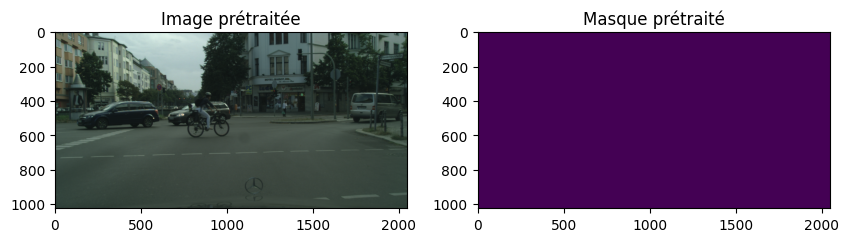

In [12]:
# Charger une image et un masque prétraités
image = cv2.imread("/home/mehdi/Documents/OC/OC8/data/raw/leftImg8bit/test/berlin/berlin_000003_000019_leftImg8bit.png")

mask = cv2.imread("/home/mehdi/Documents/OC/OC8/data/raw/gtFine/test/berlin/berlin_000003_000019_gtFine_instanceIds.png",
                  cv2.IMREAD_UNCHANGED)
mask = mask.astype(np.uint8) 

# Afficher les valeurs uniques dans le masque AVANT le remapping
print("Valeurs uniques dans le masque AVANT remapping :", np.unique(mask))

# Remaapper les classes du masque
remapped_mask = remap_classes(mask, CLASS_MAPPING)

# Afficher les valeurs uniques dans le masque APRES le remapping
print("Valeurs uniques dans le masque APRES remapping:", np.unique(remapped_mask))


# Afficher l'image et le masque
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Image prétraitée")
plt.subplot(1, 2, 2)
plt.imshow(remapped_mask) # Utiliser le masque remappé pour l'affichage
plt.title("Masque prétraité")
plt.show()